# Análise do PIB de países com Rede Neural Recorrente (RNN) Predição

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster,HeatMap,HeatMapWithTime
import branca.colormap as colormap
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import geopandas as gpd
from shapely.geometry import Point

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# # Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "rnn"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Funcoes

In [3]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    # for x in unique_list:
    #     print (x)
    return unique_list

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    # plt.hlines(0, 0, 100, linewidth=1)
    # plt.axis([0, n_steps + 1, -1, 1])

In [5]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(
        np.arange(len(val_loss)) + 1,
        val_loss,
        "r.-",
        label="Validation loss",
    )
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 2])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

## Carregando o dataset com os dados dos países

In [6]:
df_latlong = pd.read_csv('countries.csv')

In [7]:
df_latlong.drop(['Importance', 'Altitude'], axis=1, inplace=True)
df_latlong.head().T

,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Latitude,33.768006,41.000028,28.000027,42.540717,-11.877577
Longitude,66.238514,19.999962,2.999983,1.573203,17.569124


In [8]:
df_gdp = pd.read_csv('gdp_per_capita.csv')

In [9]:
df_gdp.drop(['Unnamed: 65', 'Code'], axis=1, inplace=True)

In [10]:
df_gdp.head().T

,0,1,2,3,4
Country Name,Aruba,Africa Eastern and Southern,Afghanistan,Africa Western and Central,Angola
1960,NaN,147.612227,59.773234,107.932233,NaN
1961,NaN,147.014904,59.8609,113.081647,NaN
1962,NaN,156.189192,58.458009,118.831107,NaN
1963,NaN,182.243917,78.706429,123.442888,NaN
...,...,...,...,...,...
2016,28452.170615,1431.778723,512.012778,1673.835527,3506.073128
2017,29350.805019,1573.063386,516.679862,1613.473553,4095.810057
2018,30253.279358,1574.978648,485.668419,1704.139603,3289.643995
2019,NaN,1530.059177,494.17935,1777.918672,2809.626088


In [11]:
countries_df_latlong = df_latlong['Country'].values
countries_df_gdp = df_gdp['Country Name'].values

mismatch = [i for i in countries_df_latlong if i not in countries_df_gdp]

print(
"countries_df_latlong: ",len(countries_df_latlong),
"\n\ncountries_df_gdp: ",len(countries_df_gdp),
"\n\nmismatch: ",len(mismatch),
"\n\nmismatch countries:", mismatch
)

countries_df_latlong:  184 

countries_df_gdp:  266 

mismatch:  25 

mismatch countries: ['Bahamas', 'Brunei', 'Burma', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Czechia', 'Diamond Princess', 'Egypt', 'Gambia', 'Holy See', 'Iran', 'Korea, South', 'Kyrgyzstan', 'Laos', 'MS Zaandam', 'Russia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Syria', 'Taiwan*', 'US', 'Venezuela', 'Western Sahara']


In [12]:
#### Depois fazer a correspondencia certinha
nodes = set(countries_df_latlong)-set(mismatch)
len(nodes)

159

In [13]:
nodes_df = [i for i in nodes]
df = df_latlong[df_latlong['Country'].isin(nodes_df)]
df.head(5).T

,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Latitude,33.768006,41.000028,28.000027,42.540717,-11.877577
Longitude,66.238514,19.999962,2.999983,1.573203,17.569124


In [14]:
df = pd.merge(df_latlong,df_gdp,how='inner',left_on=['Country'],right_on=['Country Name'])

df.drop(['Country Name'], axis=1, inplace=True)
df = df.rename({'Latitude': 'Lat', 'Longitude': 'Lon'}, axis=1)  # new method

df.head().T

,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Lat,33.768006,41.000028,28.000027,42.540717,-11.877577
Lon,66.238514,19.999962,2.999983,1.573203,17.569124
1960,59.773234,NaN,246.303751,NaN,NaN
1961,59.8609,NaN,214.77198,NaN,NaN
...,...,...,...,...,...
2016,512.012778,4124.05539,3946.452447,37475.635059,3506.073128
2017,516.679862,4531.019374,4109.698217,38964.904478,4095.810057
2018,485.668419,5287.663694,4142.018558,41791.969837,3289.643995
2019,494.17935,5395.659532,3989.668276,40897.330873,2809.626088


In [15]:
df.columns

Index(['Country', 'Lat', 'Lon', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020'],
      dtype='object')

## Arrumando os dados

array([[<AxesSubplot:title={'center':'Lat'}>,
        <AxesSubplot:title={'center':'Lon'}>,
        <AxesSubplot:title={'center':'1960'}>,
        <AxesSubplot:title={'center':'1961'}>,
        <AxesSubplot:title={'center':'1962'}>,
        <AxesSubplot:title={'center':'1963'}>,
        <AxesSubplot:title={'center':'1964'}>,
        <AxesSubplot:title={'center':'1965'}>],
       [<AxesSubplot:title={'center':'1966'}>,
        <AxesSubplot:title={'center':'1967'}>,
        <AxesSubplot:title={'center':'1968'}>,
        <AxesSubplot:title={'center':'1969'}>,
        <AxesSubplot:title={'center':'1970'}>,
        <AxesSubplot:title={'center':'1971'}>,
        <AxesSubplot:title={'center':'1972'}>,
        <AxesSubplot:title={'center':'1973'}>],
       [<AxesSubplot:title={'center':'1974'}>,
        <AxesSubplot:title={'center':'1975'}>,
        <AxesSubplot:title={'center':'1976'}>,
        <AxesSubplot:title={'center':'1977'}>,
        <AxesSubplot:title={'center':'1978'}>,
        <Axes

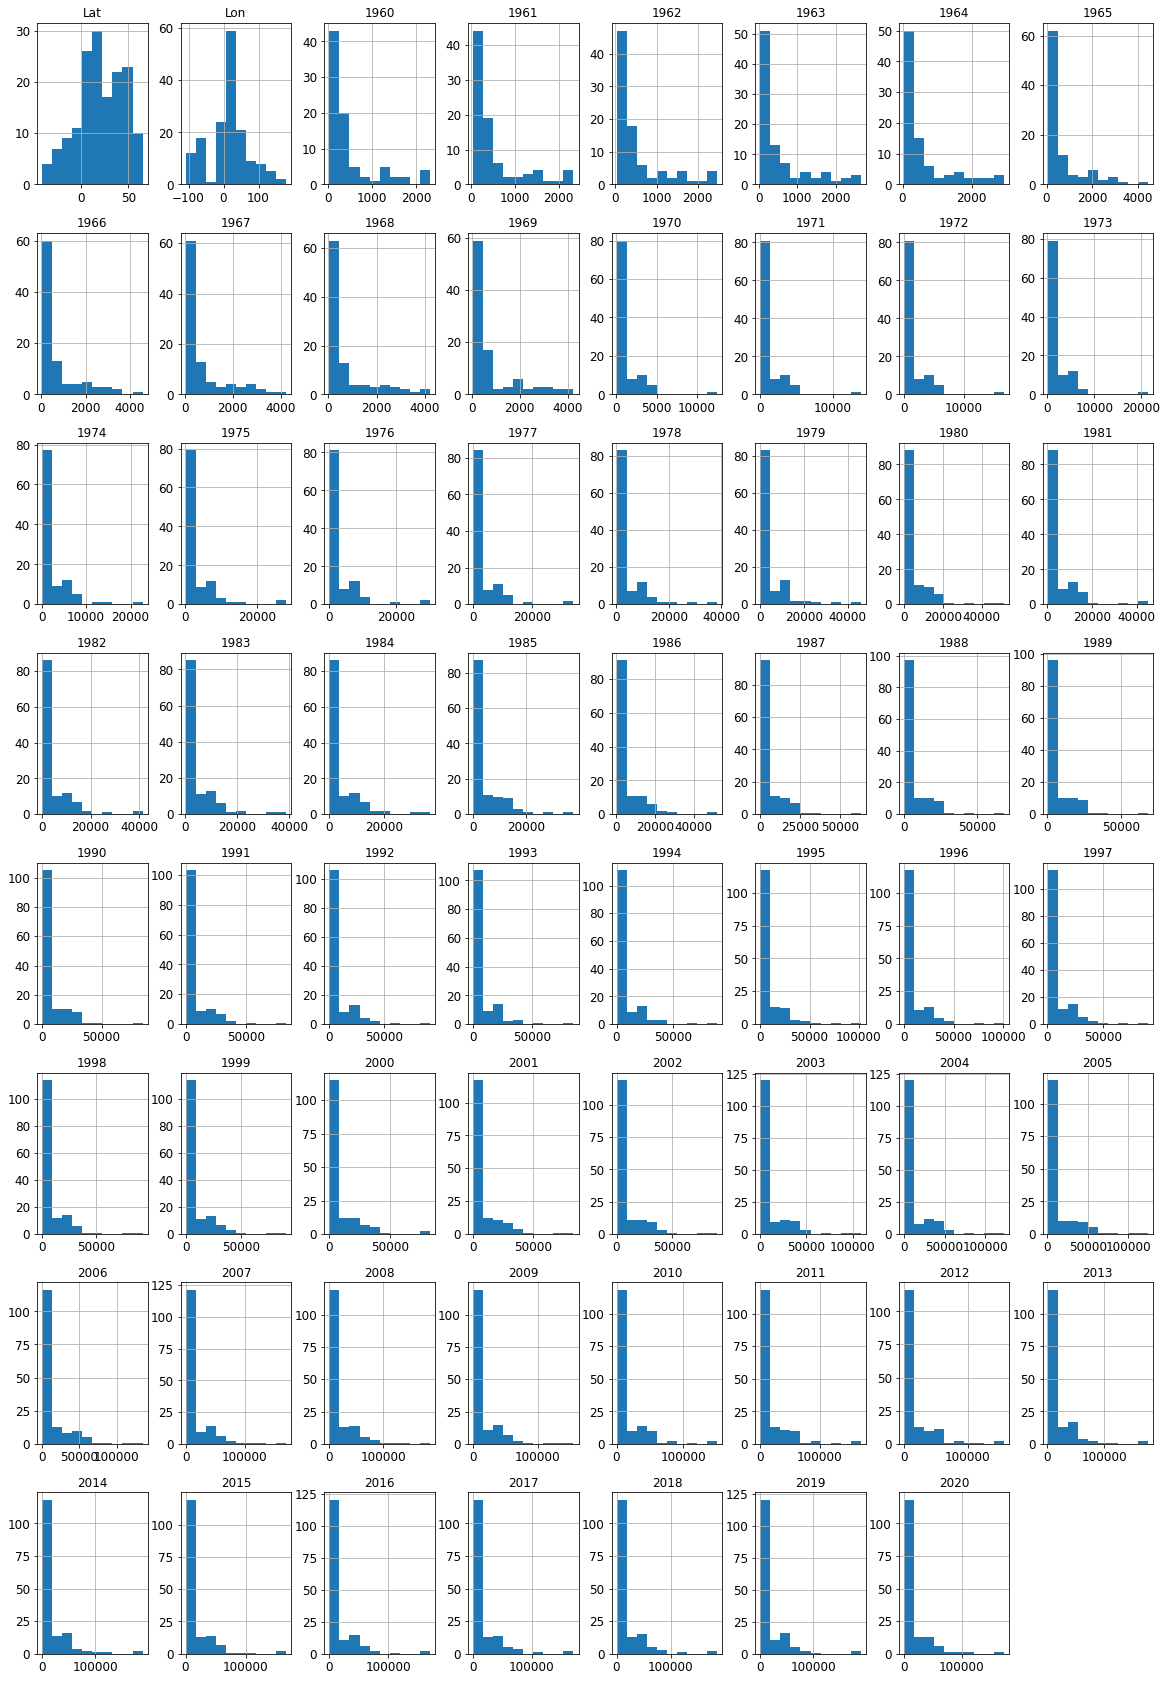

In [16]:
df.hist(figsize=(20,30))

In [17]:
GDP_years = list(set(df.columns) - {'Country', 'Lat', 'Lon'})

In [18]:
for column in GDP_years:
    df[column] = np.log10(df[column])

array([[<AxesSubplot:title={'center':'Lat'}>,
        <AxesSubplot:title={'center':'Lon'}>,
        <AxesSubplot:title={'center':'1960'}>,
        <AxesSubplot:title={'center':'1961'}>,
        <AxesSubplot:title={'center':'1962'}>,
        <AxesSubplot:title={'center':'1963'}>,
        <AxesSubplot:title={'center':'1964'}>,
        <AxesSubplot:title={'center':'1965'}>],
       [<AxesSubplot:title={'center':'1966'}>,
        <AxesSubplot:title={'center':'1967'}>,
        <AxesSubplot:title={'center':'1968'}>,
        <AxesSubplot:title={'center':'1969'}>,
        <AxesSubplot:title={'center':'1970'}>,
        <AxesSubplot:title={'center':'1971'}>,
        <AxesSubplot:title={'center':'1972'}>,
        <AxesSubplot:title={'center':'1973'}>],
       [<AxesSubplot:title={'center':'1974'}>,
        <AxesSubplot:title={'center':'1975'}>,
        <AxesSubplot:title={'center':'1976'}>,
        <AxesSubplot:title={'center':'1977'}>,
        <AxesSubplot:title={'center':'1978'}>,
        <Axes

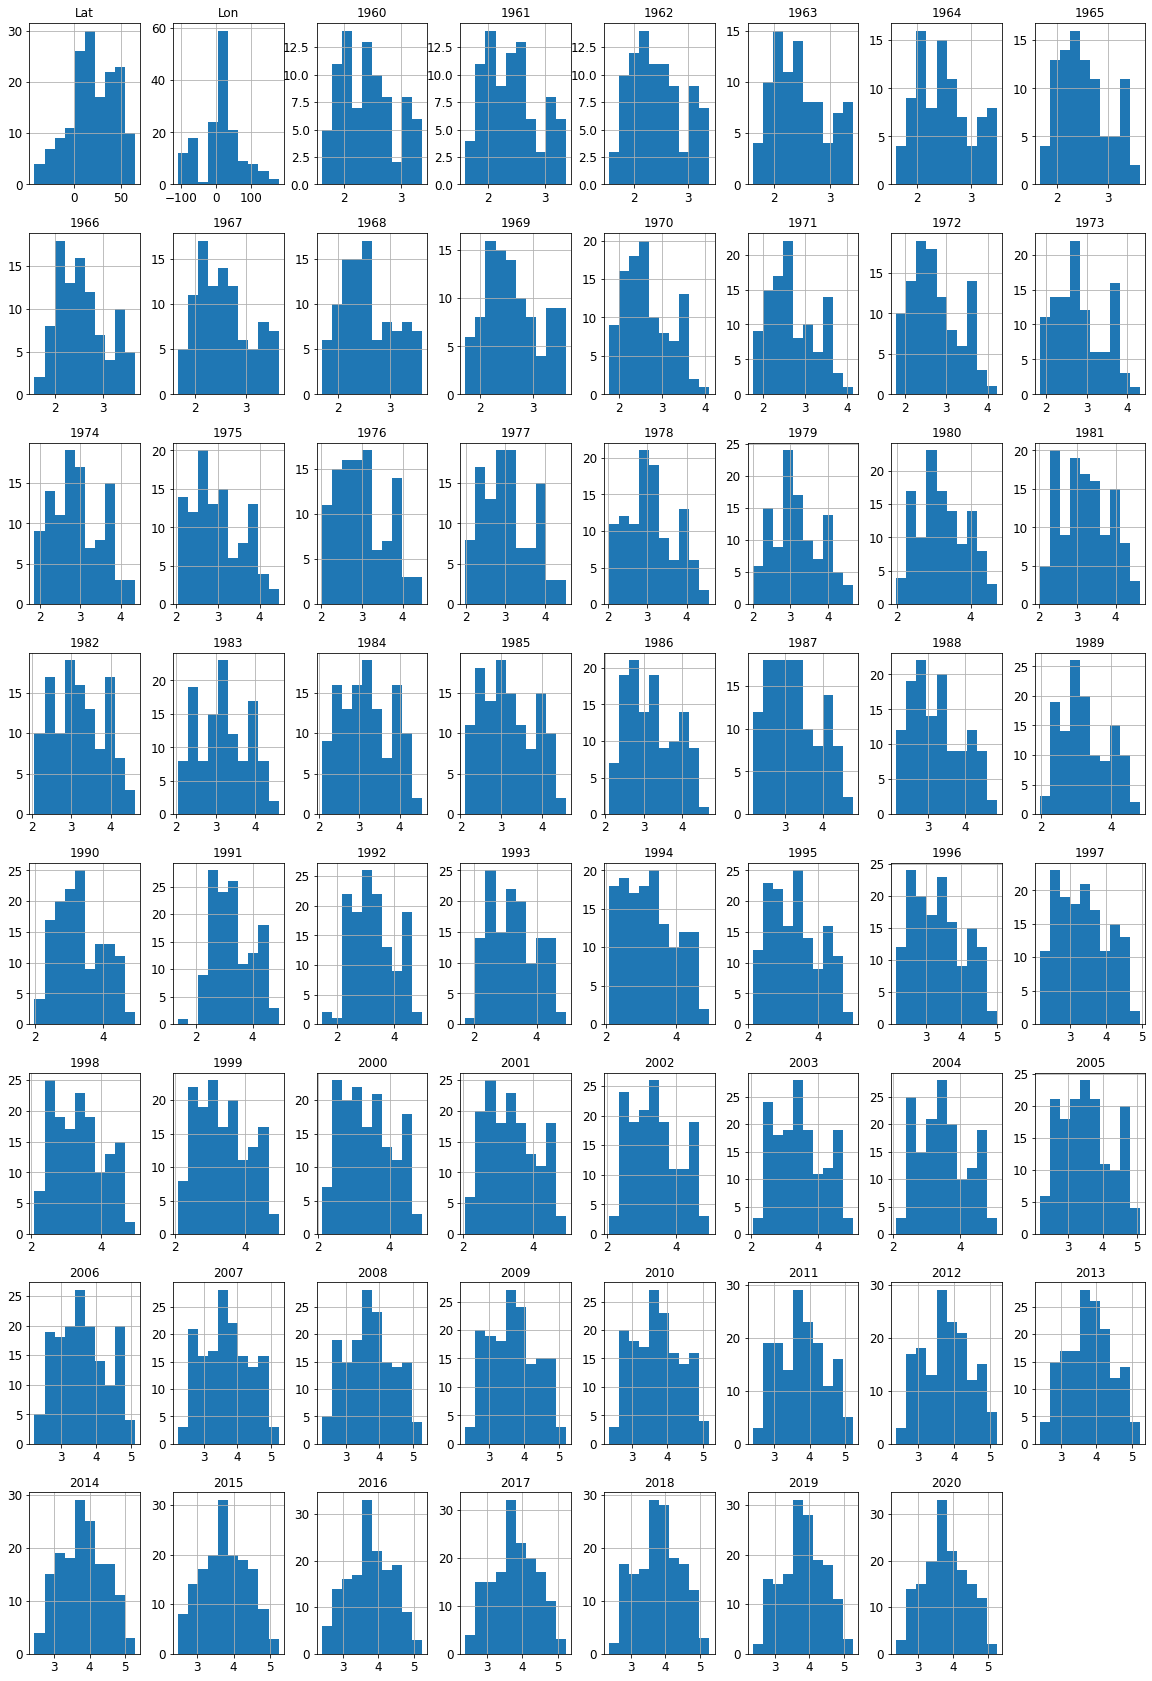

In [19]:
df.hist(figsize=(20,30))

In [20]:
df = df.melt(id_vars=['Country', 'Lat', 'Lon'], 
        var_name="Year", 
        value_name="GDP")

## Analisando os dados

In [21]:
df.groupby("Country")['GDP'].count()

Country
Afghanistan           41
Albania               37
Algeria               61
Andorra               50
Angola                38
                      ..
Uzbekistan            31
Vietnam               36
West Bank and Gaza    27
Zambia                61
Zimbabwe              61
Name: GDP, Length: 159, dtype: int64

In [22]:
data = df.copy()

In [23]:
data.describe()

,Lat,Lon,GDP
count,9699.000000,9699.000000,7944.000000
mean,19.992953,15.263292,3.302753
std,24.147219,56.528889,0.759844
min,-41.500083,-107.991707,1.357846
25%,4.706435,-7.889626,2.694405
50%,18.115296,19.015617,3.252151
75%,41.323730,38.652120,3.862819
max,64.984182,179.012274,5.277580


In [24]:
data.notna().sum()

Country    9699
Lat        9699
Lon        9699
Year       9699
GDP        7944
dtype: int64

c:\Users\samuel.nporto\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

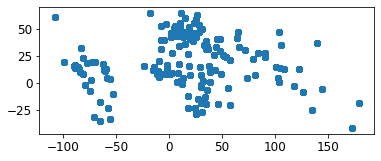

In [25]:
# Convert it to a GeoDataFrame by transforming the Latitude/Longitude coordinates 
loc_crs = {'init': 'epsg:4326'}
loc_geom = [Point(xy) for xy in zip(df['Lon'], df['Lat'])]
geo_df = gpd.GeoDataFrame(df, crs=loc_crs, geometry=loc_geom)

# Plot the GeoDataFrame
geo_df.plot()

## Arrumando dataset para entrada do modelo

In [26]:
del df['geometry']
colunas = df.columns.tolist()

In [27]:
lista_unica = unique(df['Country'].tolist())       

In [28]:
dataset = []
for pais in lista_unica:
   data_pais = df[df["Country"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   linha = 0
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
 
   while linha<len(gdp)-3: 
    #  dataset_array = []
    
     gdp_1 = gdp[linha]
     gdp_2 = gdp[linha+1]
     gdp_3 = gdp[linha+2]
     gdp_4 = gdp[linha+3]
     gdp_5 = gdp[linha+4]

    #  print("gdp_1 {0}".format(gdp_1))
    #  print("gdp_2 {0}".format(gdp_2))
    #  print("gdp_3 {0}".format(gdp_3))
    #  print("gdp_4 {0}".format(gdp_4))
    #  print("gdp_5 {0}".format(gdp_5))
     if math.isnan(gdp_1) or math.isnan(gdp_2) or math.isnan(gdp_3) or math.isnan(gdp_4) or math.isnan(gdp_5):
       nan = 0
      #  print(gdp_1[0])
      #  print("nan")
     else:
       dataset.append([latitude_pais, longitude_pais, gdp_1, gdp_2, gdp_3, gdp_4, gdp_5])

      
      # dataset.append(dataset_array)
     linha +=4

print(dataset)    


[[33.7680065, 66.2385139, 1.77650675159198, 1.7771432420529094, 1.7668440175547175, 1.896010207182971, 1.9143183288048449], [33.7680065, 66.2385139, 1.9143183288048449, 2.0047869164597008, 2.1386004366950297, 2.206551817632813, 2.1109541995868426], [33.7680065, 66.2385139, 2.1109541995868426, 2.11169847286774, 2.194566430088779, 2.2029444653346357, 2.1313530925402], [33.7680065, 66.2385139, 2.1313530925402, 2.155775119482888, 2.2396838529449705, 2.2707040741998634, 2.2954472567459296], [33.7680065, 66.2385139, 2.2954472567459296, 2.3506840357202976, 2.3933190919676366, 2.440496802935192, 2.435614278936726], [33.7680065, 66.2385139, 2.325068155125743, 2.3838715571348947, 2.4211654660673183, 2.555932176686303, 2.5618923460356995], [33.7680065, 66.2385139, 2.5618923460356995, 2.6407484313155045, 2.735044921794613, 2.7717271015337337, 2.805396079015299], [33.7680065, 66.2385139, 2.805396079015299, 2.7954040857303757, 2.7883263169355805, 2.7450804317977333, 2.7092807996512605], [33.7680065,

In [29]:
my_array = np.array(dataset)
dataset = my_array.astype('float32')
# Normalizando os Valores
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.706847  , 0.60706556, 0.07865071, ..., 0.05209646, 0.13729608,
        0.11500645],
       [0.706847  , 0.60706556, 0.11500645, ..., 0.15247476, 0.2165213 ,
        0.16688049],
       [0.706847  , 0.60706556, 0.16688049, ..., 0.16758627, 0.215601  ,
        0.17226183],
       ...,
       [0.21641307, 0.47991863, 0.28330946, ..., 0.37884116, 0.4288642 ,
        0.43191355],
       [0.21641307, 0.47991863, 0.43191355, ..., 0.42740548, 0.45973602,
        0.44513446],
       [0.21641307, 0.47991863, 0.44513446, ..., 0.41166365, 0.4494321 ,
        0.4236831 ]], dtype=float32)

In [30]:
# dataset_final=[]
# for linha in dataset:
#   linha_final = []
#   for c in linha:
#     linha_final.append([c])
#   dataset_final.append(linha_final)
# my_array = np.array(dataset_final)
# dataset = my_array.astype('float32')
# print(dataset)

## Separando em treinamento, validacao e teste

In [31]:
n_steps = 6 #CADA LISTA DENTRO DA LISTA VAI TER 7 DADOS

setenta_porc= int((70*len(dataset))/100)
vint_poc = int((20*len(dataset))/100)
nov_porc=setenta_porc+vint_poc

X_train, y_train = dataset[:setenta_porc, :n_steps], dataset[:setenta_porc, -1]
X_valid, y_valid = dataset[setenta_porc:nov_porc, :n_steps], dataset[setenta_porc:nov_porc, -1]
X_test, y_test = dataset[nov_porc:, :n_steps], dataset[nov_porc:, -1]

In [32]:
X_train.shape, y_train.shape

((1332, 6), (1332,))

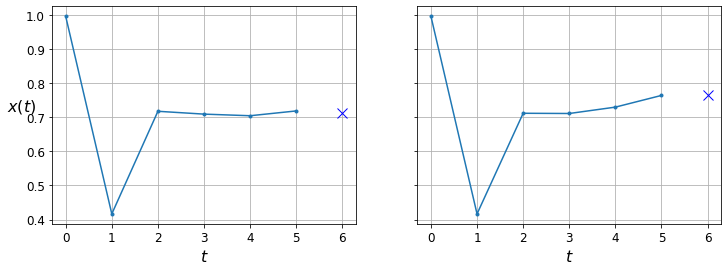

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4))
for col in range(2):
    plt.sca(axes[col])
    plot_series(
        X_valid[col, :],
        y_valid[col],
        y_label=("$x(t)$" if col == 0 else None),
    )
plt.show()

In [34]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.00037205196

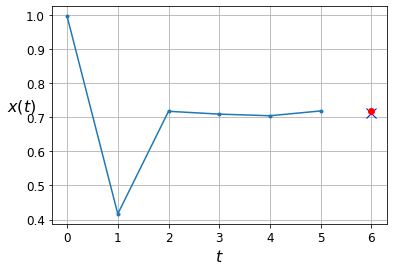

In [35]:
plot_series(X_valid[0, :], y_valid[0], y_pred[0])
plt.show()

## Linear predictions:

In [36]:
model = keras.models.Sequential([
    # keras.layers.Flatten(input_shape=[6, 1]),
    keras.layers.Dense(1,input_shape=[6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=128, #128
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
11/11 [==============================] - 1s 16ms/step - loss: 0.0260 - val_loss: 0.0211
Epoch 2/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0156 - val_loss: 0.0090
Epoch 3/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0113 - val_loss: 0.0074
Epoch 4/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0056
Epoch 5/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 6/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 7/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 8/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 9/80
11/11 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 10/80
11/11 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 11/80
11/11 

In [37]:
model.evaluate(X_valid, y_valid) #Erro medio quadratico

12/12 [==============================] - 0s 1ms/step - loss: 3.9969e-04


0.00039968773489817977

In [38]:
model.layers[0].get_weights()

[array([[ 0.00477882],
        [ 0.00155255],
        [-0.2889409 ],
        [ 0.2000579 ],
        [ 0.6328863 ],
        [ 0.43448025]], dtype=float32),
 array([0.01782654], dtype=float32)]

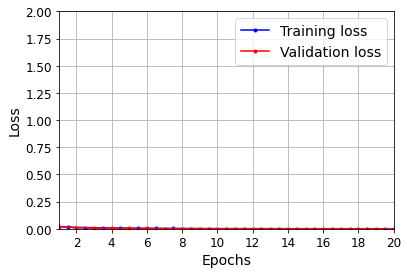

In [39]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

12/12 [==============================] - 0s 1ms/step


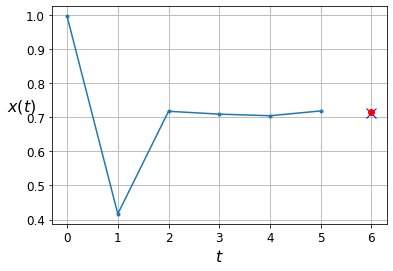

In [40]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :], y_valid[0], y_pred[0])
plt.show()

## Simple RNN

###Validação 1 

In [41]:
print(X_train.shape)
print(X_valid.shape)
X_train = X_train.reshape((1332,1,6))
X_valid = X_valid.reshape((380,1,6))
print(X_train.shape)
print(X_valid.shape)

(1332, 6)
(380, 6)
(1332, 1, 6)
(380, 1, 6)


In [42]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,6]),
])

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 8         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [44]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=20, #20
    batch_size=180, #180
    validation_data=(X_valid, y_valid),
)

Epoch 1/20
8/8 [==============================] - 1s 29ms/step - loss: 0.3635 - val_loss: 0.1587
Epoch 2/20
8/8 [==============================] - 0s 5ms/step - loss: 0.1276 - val_loss: 0.0540
Epoch 3/20
8/8 [==============================] - 0s 5ms/step - loss: 0.0498 - val_loss: 0.0437
Epoch 4/20
8/8 [==============================] - 0s 4ms/step - loss: 0.0398 - val_loss: 0.0493
Epoch 5/20
8/8 [==============================] - 0s 5ms/step - loss: 0.0413 - val_loss: 0.0502
Epoch 6/20
8/8 [==============================] - 0s 6ms/step - loss: 0.0400 - val_loss: 0.0465
Epoch 7/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0367 - val_loss: 0.0413
Epoch 8/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0335 - val_loss: 0.0368
Epoch 9/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0312 - val_loss: 0.0337
Epoch 10/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0295 - val_loss: 0.0314
Epoch 11/20
8/8 [=====================

In [45]:
model.evaluate(X_valid, y_valid) #

12/12 [==============================] - 0s 1ms/step - loss: 0.0161


0.016100358217954636

In [46]:
model.layers[0].get_weights()

[array([[-0.5088774 ],
        [ 0.49951074],
        [ 0.94938666],
        [ 0.48680735],
        [-0.19725986],
        [ 0.03861207]], dtype=float32),
 array([[1.]], dtype=float32),
 array([0.08857952], dtype=float32)]

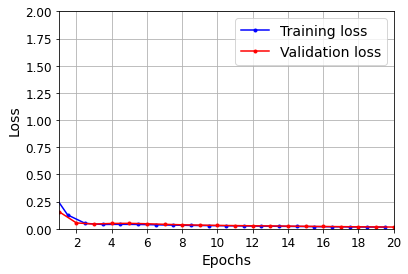

In [47]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

12/12 [==============================] - 0s 816us/step


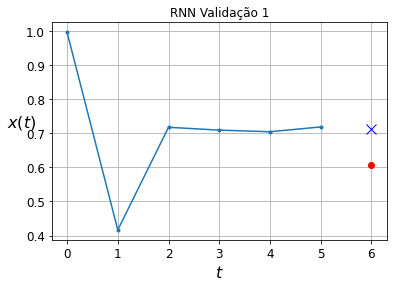

In [48]:
y_pred = model.predict(X_valid)

X_valid = X_valid.reshape((380, 6))
plot_series(X_valid[0, :], y_valid[0], y_pred[0])
plt.title("RNN Validação 1")
plt.show()

### Validação 2

In [49]:
X_train = X_train.reshape((1332,1,6))
X_valid = X_valid.reshape((380,1,6))


In [50]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,6]),
])

In [51]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=180, #180
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
8/8 [==============================] - 2s 58ms/step - loss: 0.1971 - val_loss: 0.0650
Epoch 2/80
8/8 [==============================] - 0s 10ms/step - loss: 0.0382 - val_loss: 0.0082
Epoch 3/80
8/8 [==============================] - 0s 10ms/step - loss: 0.0079 - val_loss: 0.0095
Epoch 4/80
8/8 [==============================] - 0s 9ms/step - loss: 0.0101 - val_loss: 0.0132
Epoch 5/80
8/8 [==============================] - 0s 9ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 6/80
8/8 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 7/80
8/8 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 8/80
8/8 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 9/80
8/8 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 10/80
8/8 [==============================] - 0s 8ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 11/80
8/8 [===================

In [52]:
model.evaluate(X_valid, y_valid) #

12/12 [==============================] - 0s 1ms/step - loss: 0.0020


0.001951616257429123

In [53]:
model.layers[0].get_weights()

[array([[ 0.01847439],
        [ 0.02150861],
        [ 0.42438093],
        [ 0.5617183 ],
        [ 0.85297716],
        [-0.5706219 ]], dtype=float32),
 array([[-1.]], dtype=float32),
 array([-0.0123888], dtype=float32)]

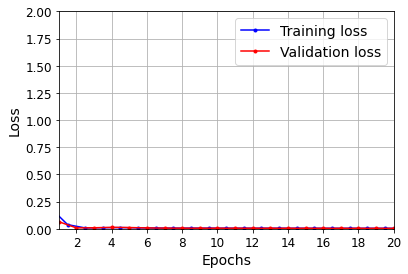

In [54]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

12/12 [==============================] - 0s 2ms/step


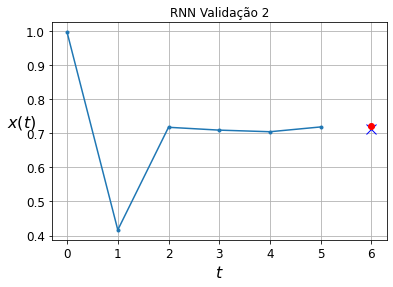

In [55]:
y_pred = model.predict(X_valid)

X_valid = X_valid.reshape((380, 6))
plot_series(X_valid[0, :], y_valid[0], y_pred[0])
plt.title("RNN Validação 2")
plt.show()

### Teste

In [56]:
X_test = X_test.reshape((192,1,6))

In [57]:
print(model.evaluate(X_test, y_test))

6/6 [==============================] - 0s 3ms/step - loss: 0.0020
0.001963341608643532


6/6 [==============================] - 0s 2ms/step


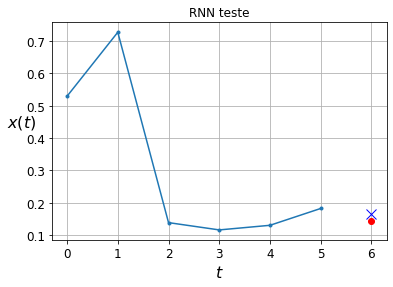

In [58]:
y_pred = model.predict(X_test)

X_test = X_test.reshape((192, 6))
plot_series(X_test[0, :], y_test[0], y_pred[0])
plt.title("RNN teste")
plt.show()

### Ano 2016 -> pais: 

In [59]:
dataset_2016 = []
pais_lista=[]
maximo=0
for pais in lista_unica:
   data_pais = df[df["Country"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
   gdp_1 = gdp[52]
   gdp_2 = gdp[53]
   gdp_3 = gdp[54]
   gdp_4 = gdp[55]
   gdp_5 = gdp[56]
   if math.isnan(gdp_1) or math.isnan(gdp_2) or math.isnan(gdp_3) or math.isnan(gdp_4) or math.isnan(gdp_5):
     nan = 0
      #  print(gdp_1[0])
      #  print("nan")
   else:
      if maximo < gdp_1 or maximo < gdp_2 or maximo < gdp_3 or maximo < gdp_4 or maximo < gdp_5:
        maximo = max(gdp_1,gdp_2,gdp_3,gdp_4,gdp_5)
      dataset_2016.append([latitude_pais, longitude_pais, gdp_1, gdp_2, gdp_3, gdp_4, gdp_5])
      pais_lista.append(pais)
      
      # dataset.append(dataset_array)

print(dataset_2016)    


[[33.7680065, 66.2385139, 2.805396079015299, 2.7954040857303757, 2.7883263169355805, 2.7450804317977333, 2.7092807996512605], [41.000028, 19.9999619, 3.6281466843131116, 3.6447400295015084, 3.6607358538205137, 3.596905119739823, 3.6153244896255887], [28.0000272, 2.9999825, 3.747584257283366, 3.740330102845113, 3.7398140814530816, 3.6209569535610346, 3.5962068741310023], [42.5407167, 1.5732033, 4.587559005657684, 4.597044626022803, 4.615991369408493, 4.553528370251751, 4.5737490010980375], [-11.8775768, 17.5691241, 3.7075784384172983, 3.7205628960298847, 3.7330697436291755, 3.619821398631861, 3.544820970182604], [17.2234721, -61.9554608, 4.122960421660318, 4.110946110552187, 4.130384623728254, 4.154890270536925, 4.181807670489101], [-34.9964963, -64.9672817, 4.116696198427254, 4.1166162017689025, 4.091132050329143, 4.139534674715464, 4.106878777769819], [40.7696272, 44.6736646, 3.566065464929581, 3.5841246455960003, 3.6005625301901993, 3.557180973404371, 3.5553155379727137], [-24.776108

In [60]:
my_array = np.array(dataset_2016)
dataset_2016 = my_array.astype('float32')
# Normalizando os Valores
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_2016 = scaler.fit_transform(dataset_2016)
dataset_2016

array([[0.706847  , 0.60706556, 0.14430475, ..., 0.12303579, 0.09494376,
        0.10422927],
       [0.77476335, 0.44595784, 0.43863642, ..., 0.43040127, 0.4060049 ,
        0.42613715],
       [0.65267956, 0.38672528, 0.48136413, ..., 0.4582619 , 0.41478777,
        0.41934484],
       ...,
       [0.68492043, 0.4960546 , 0.38806224, ..., 0.38269132, 0.37603474,
        0.40203303],
       [0.25338447, 0.4722988 , 0.3020233 , ..., 0.2843216 , 0.2342453 ,
        0.24570662],
       [0.21641307, 0.47991863, 0.2552774 , ..., 0.25286287, 0.24641943,
        0.26639587]], dtype=float32)

In [61]:
n_steps = 6
X_2016, y_2016 = dataset_2016[:, :n_steps], dataset_2016[:, -1]
# print(X_2016)
# print(y_2016)

In [62]:
y_2016.shape

(156,)

In [63]:
X_2016.shape

(156, 6)

In [64]:
X_2016 = X_2016.reshape((156,1,6))

In [65]:
print(model.evaluate(X_2016, y_2016))

5/5 [==============================] - 0s 2ms/step - loss: 0.0059
0.005943994503468275


5/5 [==============================] - 0s 2ms/step


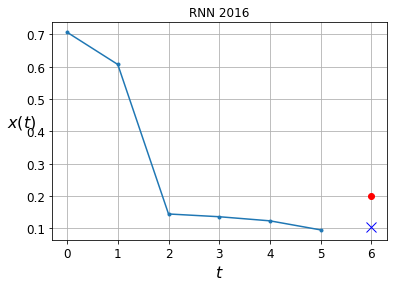

In [66]:
y_pred = model.predict(X_2016)

X_2016 = X_2016.reshape((156, 6))
plot_series(X_2016[0, :], y_2016[0], y_pred[0])
plt.title("RNN 2016")
plt.show()

In [67]:
print(y_2016)
y_2016_pred = y_pred.reshape(156)
# y_2016_pred=[]
# for y in y_pred

[0.10422927 0.42613715 0.41934484 0.7666554  0.40108806 0.6274026
 0.60078126 0.40481657 0.81077975 0.79583424 0.41675395 0.68867713
 0.25960892 0.64377457 0.4570753  0.7841839  0.45137733 0.2204315
 0.3734222  0.38092822 0.45570034 0.5073963  0.5414985  0.51984173
 0.14987189 0.         0.38362974 0.24434954 0.26089066 0.78539747
 0.06697798 0.1510331  0.6119862  0.5301866  0.4806283  0.5910849
 0.31550056 0.59758145 0.5295455  0.7017407  0.82490593 0.36650866
 0.529931   0.5138437  0.48552555 0.4137531  0.55078405 0.65591043
 0.39750212 0.1562131  0.47474843 0.790662   0.7648403  0.5074294
 0.4238041  0.7846368  0.31229275 0.652746   0.556963   0.4279688
 0.15944248 0.14374512 0.47905964 0.24685568 0.33779103 0.60456055
 0.84430665 0.29232174 0.40356523 0.4413256  0.8463617  0.76605564
 0.7370836  0.45095664 0.7743848  0.42804474 0.5227768  0.27265638
 0.41185898 0.7197556  0.61823505 0.52154976 0.16124886 0.42277616
 0.9959672  0.6253523  0.92828757 0.09296143 0.02965438 0.5599709
 

In [68]:

data = {'Pais': pais_lista ,
        '2016':[(item * maximo) for item in y_2016] ,
         '2016 predição':[(item * maximo) for item in y_2016_pred],
        }

df = pd.DataFrame(data)
df

,Pais,2016,2016 predição
0,Afghanistan,0.550065,1.051747
1,Albania,2.248919,2.748256
2,Algeria,2.213073,2.943781
3,Andorra,4.045989,4.014897
4,Angola,2.116724,2.879168
...,...,...,...
151,Uzbekistan,1.905398,2.217814
152,Vietnam,1.734320,2.000242
153,West Bank and Gaza,2.121711,2.468437
154,Zambia,1.296705,2.051760
